# 2021-10-26 Timeline stats

Beginnings of statistical analysis based on the timeline stats of users, NOT the clustering word data yet. Also should I get the follows?

In [1]:
import os
import pprint
import tqdm
import json
import glob
import jsonlines
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import sys
from collections import Counter
sys.path.insert(0, '../src/d07_visualisation/')
import datetime

from plot_timeline_completeness import generate_cdf_values

In [43]:
with open('../data/02_intermediate/interaction_edges.obj', 'rb') as f:
    interaction_dict = pickle.load(f)

with open('../references/search_hashtags.txt', 'r') as f:
    search_hashtags = f.readlines()
    search_hashtags = [i.replace('\n', '') for i in search_hashtags]
    search_hashtags = [i.replace('#', '') for i in search_hashtags]
    search_hashtags = [i.lower() for i in search_hashtags]


In [4]:
print(len(interaction_dict))

4186


<AxesSubplot:xlabel='value'>

<Figure size 432x288 with 0 Axes>

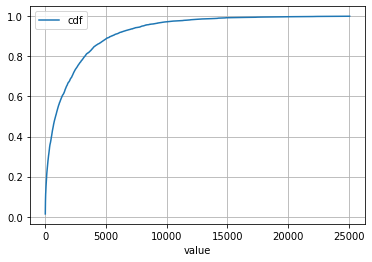

In [5]:
#2021-11-02 plot the lengths of each user's entry in interaction_dict

user_interaction_counts = []
for k,v in interaction_dict.items():
    user_interaction_counts.append(len(v))

f = plt.figure()
cdf_interaction_counts = generate_cdf_values(user_interaction_counts)
cdf_interaction_counts.plot(x = 'value', y = 'cdf', grid = True)

In [18]:
def get_user_activity_counts(timeline_jsonl_file, level='daily', hashtag_search = True):

    output = Counter()

    tweet_counts = []
    hashtagged_tweets = []
    with jsonlines.open(timeline_jsonl_file) as reader:
        for tweet_json in reader:
            for tweet_data in tweet_json['data']:
                tweet_created_at = datetime.datetime.fromisoformat(tweet_data['created_at'][:-1])

                if hashtag_search:
                    if 'entities' in tweet_data:
                        if 'hashtags' in tweet_data['entities']:
                            # print([i['tag'] for i  in tweet_data['entities']['hashtags']])
                            # break
                            if any([i['tag'].lower() in search_hashtags for i in tweet_data['entities']['hashtags']]):
                                hashtagged_tweets.append(tweet_created_at)
                    else:
                        tweet_counts.append(tweet_created_at)
                else:
                    tweet_counts.append(tweet_created_at)


    # convert to the level required
    if level == 'daily':
        tweet_counts = [i.date() for i in tweet_counts]
    elif level == 'monthly':
        # replace day for all tweets to just be first of each month they are in
        tweet_counts = [i.date().replace(day=1) for i in tweet_counts]

    output = Counter(tweet_counts)
    output_hashtagged = Counter(hashtagged_tweets)

    if hashtag_search:
        return output, output_hashtagged
    else:
        return output


In [16]:
timeline_flist = glob.glob('../data/01_raw/timeline*.jsonl')

In [40]:
nonzero = []
for i,e in enumerate(timeline_flist):
    x = get_user_activity_counts(e, level = 'monthly', hashtag_search = True)
    if len(x[1]) >0:
        nonzero.append(i)

In [41]:
nonzero

[631, 1276, 1356, 1455, 3190, 3618]

In [46]:
# check nature of referenced tweets
for i in tqdm.tqdm(timeline_flist):
    with jsonlines.open(i) as reader:
        for tweet_jsonl in reader:
            tweet_includes = tweet_jsonl['includes']
            current_user_id = tweet_jsonl['data'][0]['author_id']
        # for reffed_users in tweet_includes['users']:
        #     print(reffed_users)
        #     break
        for tweet in tweet_jsonl['data']:
            if 'referenced_tweets' in tweet and len(tweet['referenced_tweets'])>1:
                print(pprint.pprint(tweet))
                break
                # types = [i['type']=='quoted' or i['type']=='replied_to' for i in tweet['referenced_tweets']]
                # if not all(types):
                #     print(tweet)



  0%|          | 7/4344 [00:02<29:58,  2.41it/s]


KeyboardInterrupt: 

In [74]:
with jsonlines.open(timeline_flist[2]) as reader:
    for tweet_jsonl in reader:
        tweet_includes = tweet_jsonl['includes']
        current_user_id = tweet_jsonl['data'][0]['author_id']
    # for reffed_users in tweet_includes['users']:
    #     print(reffed_users)
    #     break
    x = tweet_jsonl['data']
    for tweet in tweet_jsonl['data']:
        # if 'referenced_tweets' in tweet and len(tweet['referenced_tweets'])==1:
        #     print(pprint.pprint(tweet))
        #     break
        # if 'retweeted_status' in tweet:
        #     print(tweet)
        #     break
        if tweet['text']<2:
            print(pprint.pprint(tweet))
            break
        # if 'in_reply_to_status'

{'author_id': '768008464148955136',
 'conversation_id': '928213660127899648',
 'created_at': '2017-11-08T13:41:33.000Z',
 'id': '928256175635947520',
 'in_reply_to_user_id': '888378203798204420',
 'lang': 'en',
 'possibly_sensitive': False,
 'public_metrics': {'like_count': 0,
                    'quote_count': 0,
                    'reply_count': 0,
                    'retweet_count': 0},
 'referenced_tweets': [{'id': '928213660127899648', 'type': 'replied_to'}],
 'reply_settings': 'everyone',
 'source': 'Twitter Web Client',
 'text': "@samjonson711 Ditto. Haven't seen this one before. Thanks :)"}
None


In [71]:
x[3]['text']

'@GadflyMorse @nytopinion Okay, Putin Troll... https://t.co/f9ZkpeLFqV'

matching based on activity: